There are a lot of scenarious when we wanna use some statistical techniques that requires the data to be normal, but it actually isn't. Data transformation may save us in this case.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import inv_boxcox
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (8, 5)
sns.set_style('whitegrid')

Let's generate a few distributions and try to make it closer to normal by uising the Box-Cox transformation.

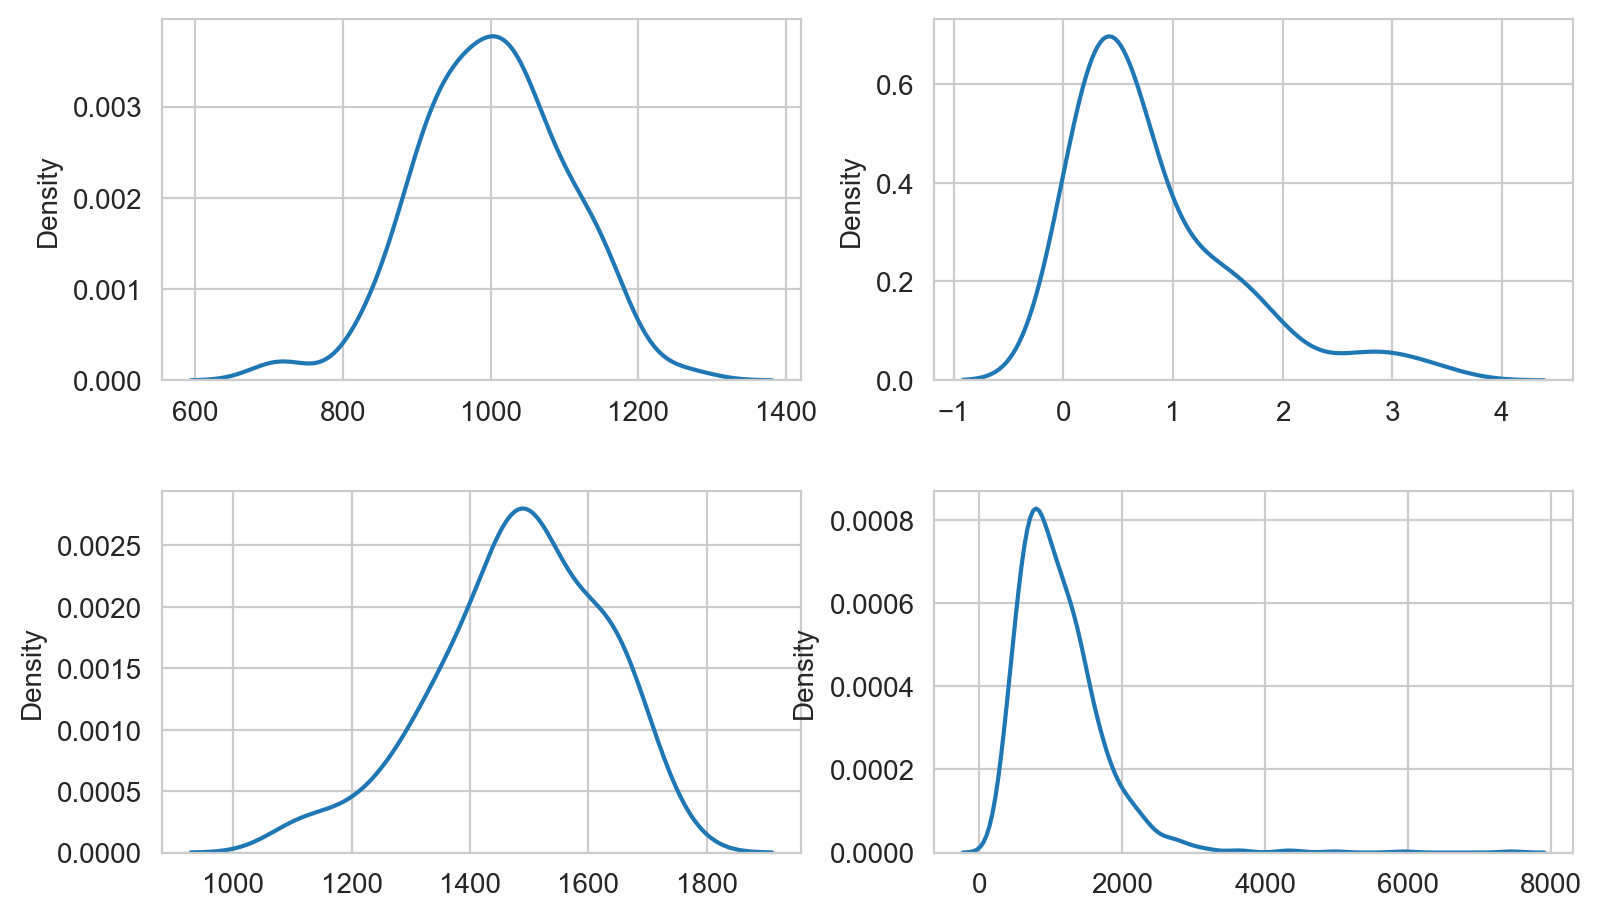

In [41]:
data1 = stats.norm.rvs(loc=1000, scale = 100, size = 100) + 10*np.random.rand(100)
data2 = stats.expon.rvs(size = 100)
data3 = stats.norm.rvs(loc=1000, scale = 100, size = 100) + stats.norm.rvs(loc=500, scale = 100, size = 100)
data4 = stats.lognorm.rvs(s = 0.5, loc=1, scale=1000, size = 1000)
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
fig.tight_layout(pad = 2)
for i in range(4):
    sns.kdeplot(eval('data'+str(i + 1)), ax = ax[i])

In [42]:
print(stats.shapiro(data1), stats.shapiro(data2), stats.shapiro(data3), stats.shapiro(data4), sep = '\n')

ShapiroResult(statistic=0.9895853400230408, pvalue=0.6311478614807129)
ShapiroResult(statistic=0.8447384238243103, pvalue=7.616731245718711e-09)
ShapiroResult(statistic=0.9722234606742859, pvalue=0.03279087319970131)
ShapiroResult(statistic=0.8292866945266724, pvalue=2.390655523414203e-31)


Most p-values of the Shapiro-Wilk test are less than standart $0.05$ (re-run of data generation process may change it), so we are unable to use the most statistical techniques. Of course, we can use non-parametric methods, but they usually have less statistical power and the parametric method are preferred.

Don't forget, that the Box-Cox transformation requires ALL data to be positive. To fix it you can simply add a large enough constant to the data.

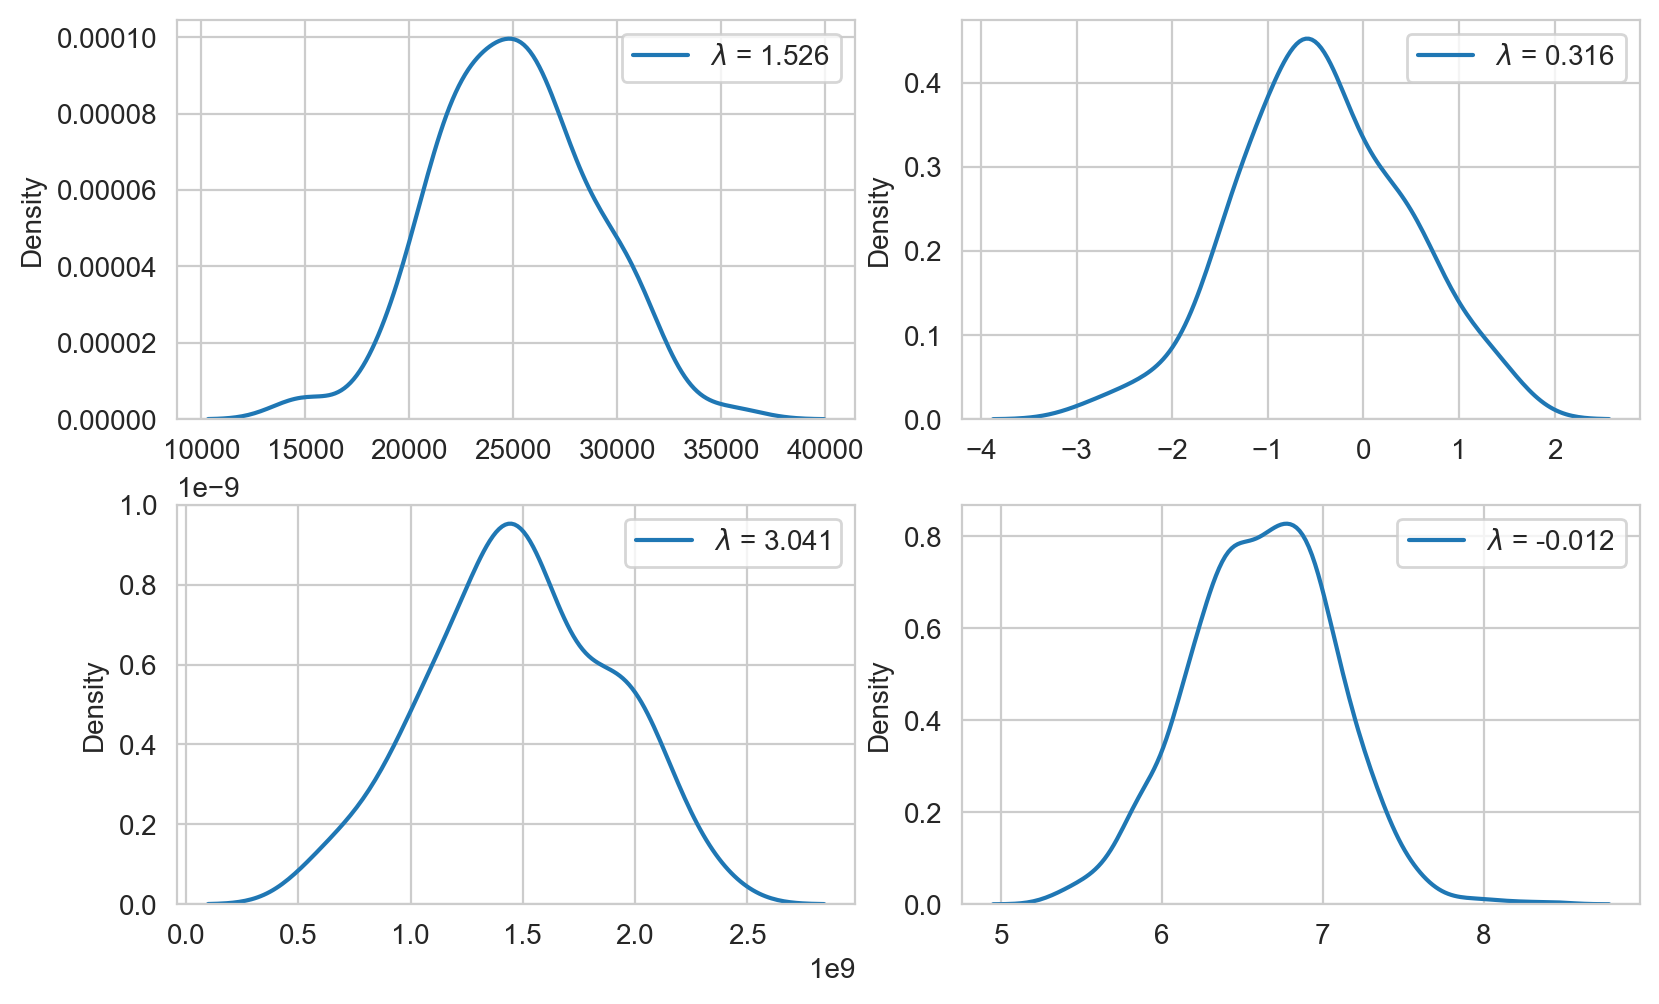

In [45]:
data1_transformed, l1 = stats.boxcox(data1)
data2_transformed, l2 = stats.boxcox(data2)
data3_transformed, l3 = stats.boxcox(data3)
data4_transformed, l4 = stats.boxcox(data4)
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
fig.tight_layout()
for i in range(4):
    sns.kdeplot(eval('data'+str(i + 1)+'_transformed'), ax = ax[i], label = f"$\lambda$ = {eval('l' + str(i+1)) :.3f}")
    ax[i].legend(loc = 1)

In [34]:
print(stats.shapiro(data1_transformed), stats.shapiro(data2_transformed),
      stats.shapiro(data3_transformed), stats.shapiro(data4_transformed), sep = '\n')

ShapiroResult(statistic=0.9876734614372253, pvalue=0.48445188999176025)
ShapiroResult(statistic=0.9944198131561279, pvalue=0.9572063088417053)
ShapiroResult(statistic=0.9881595969200134, pvalue=0.5200476050376892)
ShapiroResult(statistic=0.9993228912353516, pvalue=0.9824427962303162)


The transformation has significantly increased the p-value of Shapiro-Wilk test, making them all possible to use as normal data (the first, in fact, passed the test even whithout transformation, but after it became "more normal"). If we were, for instance,  to find a confidence interval, we can't just use the one we get from our transformed data, the inverse transformation is needed. To do so we can simply implement inv_boxcox function from scipy.special.

Note that confidence interval for mean, for example, will lie since the sum of powers is not equal to power of sums $\left((a + b)^2 \neq a^2 + b^2\right)$:

In [14]:
data4.mean() - inv_boxcox(data4_transformed.mean(), l4)

127.55202368341816

And we must be extremely cautious when drawing any conclusions from the transformed data.

In [15]:
# Three sigma
mean = data4_transformed.mean()
std = data4_transformed.std(ddof = 1)

lower = mean - 3 * std
upper = mean + 3 * std
print((lower, upper))
print('Interval is not even close to real data4')

(6.124496851174378, 10.459115671254523)
Interval is not even close to real data4


In [16]:
print(tuple(inv_boxcox((lower, upper), l4)))
print('This one is much better')

(205.52636958308503, 4325.966840639945)
This one is much better


To be honest, I'm not really sure 3-sigma interval works better than confidence interval(which doesn't work, I tried), but I found an article whos author used it, so...